<a href="https://colab.research.google.com/github/unninakul/meat-quality-assessment/blob/main/Meat_Quality_Analysis_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import modules
import tensorflow as tf
import numpy as np
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Image Conversion
import os
from PIL import Image

folder_path = "/content/drive/MyDrive/meat data.file.zip (Unzipped Files)"
file_list = os.listdir(folder_path)

for file_name in file_list:
    if file_name.lower().endswith((".png", ".jpg", ".jpeg")):
        file_path = os.path.join(folder_path, file_name)

        try:
            image = Image.open(file_path)
        except Exception as e:
            print(f"Error opening {file_name}: {str(e)}")
            continue

        new_file_path = os.path.splitext(file_path)[0] + ".jpg"

        try:
            image.save(new_file_path, "JPEG")
        except Exception as e:
            print(f"Error converting {file_name} to JPEG: {str(e)}")
            continue

        os.remove(file_path)
        os.rename(new_file_path, file_path)
        print(f"{file_name} converted to JPEG and replaced successfully.")

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30


In [ ]:
#Importing Dataset
import tensorflow as tf

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/meat data.file.zip (Unzipped Files)",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)


Found 1896 files belonging to 2 classes.


In [ ]:
#Data Preperation
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

print(image_batch[0].numpy())
print(image_batch[0])
print(image_batch[0].shape)


(32, 256, 256, 3)
[0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1]
[[[119.09375 126.09375 119.09375]
  [117.625   124.625   117.625  ]
  [101.84375 108.84375 101.84375]
  ...
  [184.90625 249.8125  251.8125 ]
  [175.09375 239.09375 241.09375]
  [183.28125 248.1875  250.1875 ]]

 [[115.5625  122.5625  115.5625 ]
  [109.25    116.25    109.25   ]
  [124.84375 131.84375 124.84375]
  ...
  [173.15625 244.59375 243.875  ]
  [175.4375  244.875   245.15625]
  [178.28125 249.71875 249.     ]]

 [[118.0625  125.0625  118.0625 ]
  [230.84375 236.25    230.84375]
  [178.28125 184.34375 178.28125]
  ...
  [171.1875  247.1875  245.1875 ]
  [168.875   243.9375  242.40625]
  [166.875   242.875   240.875  ]]

 ...

 [[236.      248.      246.     ]
  [236.      248.      246.     ]
  [236.      248.      246.     ]
  ...
  [131.46875 215.46875 199.46875]
  [130.      214.      198.     ]
  [134.53125 218.53125 202.53125]]

 [[236.      248.      246.     ]
  [236.      248.      246. 

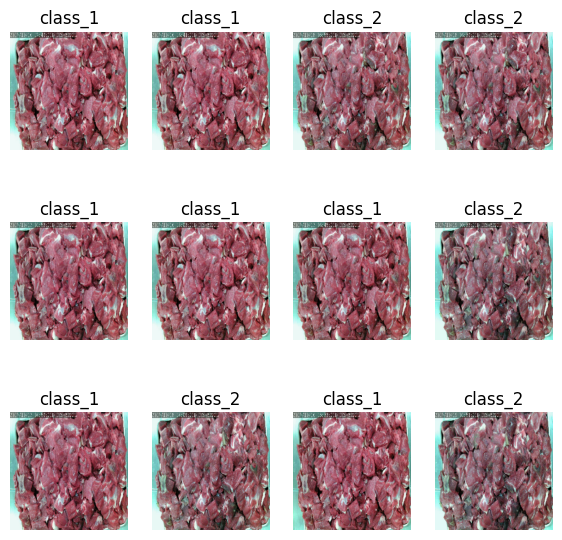

In [ ]:
#Data Exploration
plt.figure(figsize=(7, 7))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        class_names = ['class_1', 'class_2', 'class_3', ...]
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
#Splitting the Dataset
import tensorflow as tf
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,
                              shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


48
6
6


In [ ]:
#Image Preprocessing
import tensorflow as tf
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.Rescaling(0.2),
    layers.experimental.preprocessing.RandomContrast(factor=0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
])